In [1]:
import os
import _pickle as cPickle
import numpy as np
from scipy.io.wavfile import read
from FeatureExtraction import extract_features
#from speakerfeatures import extract_features
import warnings
warnings.filterwarnings("ignore")
import time
import sys
import glob

In [11]:
subset = "a1"
# subset = "training_e"

# test = "normalized"
# subset = "testing_different"

source = f"dataset_cm/{subset}/"

#path where training speakers will be saved
modelpath = "models"

gmm_files = [os.path.join(modelpath,fname) for fname in 
              os.listdir(modelpath) if fname.endswith('.gmm')]

#Load the Gaussian Models
models    = [cPickle.load(open(fname,'rb')) for fname in gmm_files]
print("Loaded Models: ", len(models))
speakers   = [fname.split("/")[-1].split(".gmm")[0] for fname 
              in gmm_files]

error = 0
total_samples = 0.0

external_class_true_count = 0
# print("Press '1' for checking a single Audio or Press '0' for testing a complete set of audio with Accuracy?")
# take=int(input().strip())

predictions = []
gender_predictions = []
gender_gt = []
y_true = []
preprocessingMisPredictions = 0
print("Testing the model with all the samples...")
false_predictions = []
file_paths = glob.glob(f"{source}/**/*.wav", recursive=True)

# Read the test directory and get the list of test audio files 
avg_time = 0
total_time = 0
for path in file_paths:
    time1 = time.time()   
    total_samples+= 1.0
    path=path.strip()
    # print("Testing Audio : ", path)
    sr,audio = read(path)
    vector   = extract_features(audio,sr)
    # print(vector.shape)
    log_likelihood = np.zeros(len(models)) 
    for i in range(len(models)):
        gmm    = models[i]  #checking with each model one by one
        scores = np.array(gmm.score(vector))
        log_likelihood[i] = scores.sum()
    winner=np.argmax(log_likelihood)
    winner_score = log_likelihood[winner]
    # print(speakers[winner]) // models\Abdelrahman Said_e1
    # print(path) // dataset_cm/e1\Abdelrahman Said_e1\Abdelrahman Said_1.wav

    predicted_speaker = speakers[winner].split('\\')[-1].split('_')[0]
    speaker_label = path.split("\\")[-1].split("_")[0]
    # print("OK score: ", winner_score)
    predictions.append(predicted_speaker)
    y_true.append(speaker_label)
    if speaker_label == "Abdelrahman" or speaker_label == "Youssef" or speaker_label == "Sherif" or speaker_label == "Omar":
        gender_predictions.append("M")
    else:
        gender_predictions.append("F")
    if predicted_speaker == "Abdelrahman" or predicted_speaker == "Youssef" or predicted_speaker == "Sherif" or predicted_speaker == "Omar":
        gender_gt.append("M")
    else:
        gender_gt.append("F")

    
    likelihoods = np.argsort(log_likelihood)[::-1]
    
    if predicted_speaker != speaker_label:
        print(f"{speaker_label}:{predicted_speaker}, ", end="")
        # print(f"False Score: {winner_score}")
        # print(path)
        error += 1

    # time.sleep(1.0)
    sample_time = time.time() - time1
    total_time += sample_time
print (error, total_samples)
accuracy = ((total_samples - error) / total_samples)

print ("Accuracy: ", round(accuracy, 4))
print(f"Average time taken per sample in ms", round((total_time/total_samples)*1000, 2))
print("Preprocessing MisPredictions: ", preprocessingMisPredictions)
# print ("The following Predictions were False :")
# print (false_predictions)
print(modelpath)
print ("Speaker Identified Successfully")


Loaded Models:  7
Testing the model with all the samples...
Abdelrahman Said:Sherif, Abdelrahman Said:Omar, Omar:Sherif, Omar:Abdelrahman Said, Omar:Sherif, Omar:Sherif, Omar:Abdelrahman Said, Omar:Sherif, Omar:Sherif, Omar:Abdelrahman Said, Omar:Abdelrahman Said, Omar:Abdelrahman Said, Reem:Renad, Renad:Reem, Renad:Reem, Renad:Silence, Sherif:Abdelrahman Said, Sherif:Omar, Sherif:Omar, Sherif:Abdelrahman Said, Sherif:Omar, Sherif:Omar, Sherif:Omar, Sherif:Silence, Sherif:Omar, Sherif:Omar, Sherif:Abdelrahman Said, Youssef:Omar, Youssef:Omar, Youssef:Omar, Youssef:Omar, Youssef:Omar, Youssef:Omar, Youssef:Omar, Youssef:Omar, Youssef:Omar, Youssef:Omar, Youssef:Omar, Youssef:Omar, Youssef:Omar, Youssef:Omar, Youssef:Omar, Youssef:Sherif, Youssef:Omar, Youssef:Abdelrahman Said, Youssef:Omar, Youssef:Abdelrahman Said, Youssef:Omar, Youssef:Omar, Youssef:Omar, Youssef:Abdelrahman Said, Youssef:Omar, Youssef:Abdelrahman Said, Youssef:Omar, Youssef:Omar, Youssef:Omar, Youssef:Omar, Youssef:A

                  precision    recall  f1-score   support

          Sherif       1.00      0.94      0.97        18
         Youssef       0.94      0.94      0.94        18
Abdelrahman Said       0.95      1.00      0.97        18
           Renad       1.00      0.94      0.97        18
            Reem       0.95      1.00      0.97        18
            Omar       1.00      1.00      1.00        18

        accuracy                           0.97       108
       macro avg       0.97      0.97      0.97       108
    weighted avg       0.97      0.97      0.97       108



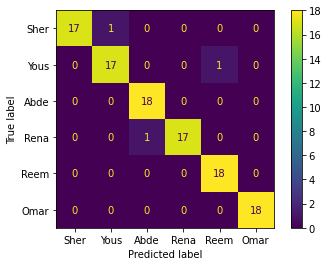

In [18]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
print(classification_report(y_true, predictions, target_names=set(y_true)))

# labels = [y_true[i][0:4] for i in range(len(y_true))]
labels = [item[:4] for item in set(y_true)]
ConfusionMatrixDisplay.from_predictions(
    y_true, predictions, display_labels=labels
)